<a href="https://colab.research.google.com/github/dottorm/student_thesis/blob/main/Copia_di_Comic_Image_Recognition_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT LIBRERIE**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from zipfile import ZipFile
import os
import shutil
import random

from google.colab import drive

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#import pdb

# **FUNZIONI CUSTOM**

In [ ]:
def analyze_dataset(dataset_path, model):
  try:
    for file in [os.path.join(dataset_path, file) for file in os.listdir(dataset_path)]:
      analyze(file, model)

    for name in class_names:
      out_path = out+model.model_name+'/'+name
      data_dir = pathlib.Path(out_path)
      f.write('{}: {}\r\n'.format(name,len(list(data_dir.glob('*.png')))))
    f.write('{}: {}\r\n'.format('to_check',len(list(pathlib.Path(out+model.model_name+'/to_check').glob('*.png')))))
  except Exception as e:
    print("An error occurred:", e) # Puoi gestire l'errore qui come desideri, ad esempio, loggarlo o sollevare un'eccezione personalizzata.

In [ ]:
def analyze(file, model):
  try:
    img = tf.keras.utils.load_img(file, target_size=(img_height,img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = predictions[0] #tf.nn.softmax(predictions[0])
    confidence = 100 * np.max(score)
    class_name = class_names[np.argmax(score)]
    print(
      "The image " + '\033[1m' + str(file) + '\033[0m' + " most likely belongs to\033[1m {} \033[0mwith a {:.2f} percent confidence."
      .format(class_name, confidence)
    )

    f.write('{},{},{:.2f}\r\n'.format(file, class_name, confidence))

    if confidence < 60.:
      #pdb.set_trace()
      output = out+model.model_name+'/to_check'
      #create_dir(output)
      shutil.copy(file,output) #shutil.move(file,output)
    else:
      #print(class_name)
      output = out+model.model_name+'/'+class_name
      #create_dir(output)
      shutil.copy(file,output)
  except Exception as e:
    print('Error analyzing image:', e)

In [ ]:
def prepare_environment(source, model_name):
  try:
    parent_folder = source
    new_folder_name = model_name
    new_folder_path = os.path.join(parent_folder, new_folder_name)
    os.makedirs(new_folder_path)
    for name in class_names:
      output = os.path.join(new_folder_path, name)
      create_dir(output)
    output = os.path.join(new_folder_path, 'to_check')
    create_dir(output)
  except FileExistsError:
      print("The folder already exists.")
  except OSError as e:
      print(f"An error occurred while creating the folder: {e}")

In [ ]:
def create_dir(directory):
  try:
    if not os.path.exists(directory):
      os.mkdir(directory)#os.makedirs(directory)
      print("Directory " + directory + " successfully created")
    else:
      print("The directory  " + directory + " already exists")
  except OSError as e:
    print("An error occurred while creating the directory:", e)

In [ ]:
def set_model_name(model, model_name):
  try:
    setattr(model, 'model_name', model_name)
    print("Attribute set successfully")
  except AttributeError as e:
    print(f"An error occurred while setting the model name: {e}")
  except Exception as e:
    print(f"A generic error occurred: {e}")

In [ ]:
def count_files(directory):
  try:
    file_count = 0
    for root, dirs, files in os.walk(directory):
      file_count += len(files)
    return file_count
  except FileNotFoundError:
    print("The specified directory does not exist.")
  except PermissionError:
    print("You do not have sufficient permissions to access the directory.")
  except Exception as e:
    print("An unexpected error occurred:", str(e))

In [ ]:
def write_total_files(image_count):
  f.write('total files : '+str(image_count)+'\r\n')
  f.write('-----'+'\r\n')

In [ ]:
def write_metric_values(history):
  f.write('trining accurancy: '+str(history.history['accuracy'])+'\r\n')
  f.write('training loss: '+str(history.history['loss'])+'\r\n')
  f.write('validation accurancy: '+str(history.history['val_accuracy'])+'\r\n')
  f.write('validation loss: '+str(history.history['val_loss'])+'\r\n')
  f.write('-----'+'\r\n')

In [ ]:
def plot_accuracy_loss(history,model_name,best_epoch):
  try:
    acc = history.history['accuracy'][:best_epoch]
    val_acc = history.history['val_accuracy'][:best_epoch]
    loss = history.history['loss'][:best_epoch]
    val_loss = history.history['val_loss'][:best_epoch]

    #epochs_range = range(epochs)
    epochs_range = range(1, best_epoch + 1)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy') #plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy') #plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss') #plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss') #plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 4)

    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(model_name)  # Aggiunta del nome del modello come titolo del grafico
    plt.savefig(out_plot + model_name + '_accuracy_loss_plot.png')
    plt.show()

  except KeyError as e:
    print("Error during plot creation: Key not found in 'history' dictionary.")
    print(f"Error details: {e}")
  except Exception as e:
    print("Error during plot creation.")
    print(f"Error details: {e}")

In [ ]:
def evaluation_model_on_test_dataset(test_dataset, model_path, model_name):
  # Carica il modello addestrato
  model = tf.keras.models.load_model(model_path) #'/content/output/initial_model.h5'

  # Carica il tuo dataset di test
  #dataset_di_test = ...  # Carica il tuo dataset di test qui

  # Valuta il modello sul dataset di test
  evaluation = model.evaluate(test_dataset)

  # # Stampa i risultati della valutazione
  # for i, metrica in enumerate(modello.metrics_names):
  #     print(f"{metrica}: {valutazione[i]}")

  # Creazione del dizionario di valutazione con nomi delle metriche come chiavi
  evaluation_results = {}
  for metric_name, metric_value in zip(model.metrics_names, evaluation):
    evaluation_results[metric_name] = metric_value

  # Stampa il nome del modello
  print(model_name+'\r\n')

  # Stampa i risultati della valutazione
  for metric_name, metric_value in evaluation_results.items():
    print(f"{metric_name}: {metric_value}")

  return evaluation_results

In [ ]:
def txt_to_csv(txt_file_path, csv_file_path):
  try:
    data = pd.read_csv(txt_file_path, sep='\t')
    data.to_csv(csv_file_path, index=False)
    print("Conversion completed successfully.")
  except FileNotFoundError:
    print("File not found. Make sure to specify the correct path of the TXT file.")
  except pd.errors.EmptyDataError:
    print("The TXT file is empty. Make sure the file contains data before converting it.")
  except Exception as e:
    print("An error occurred during the conversion:", str(e))

# **CARICAMENTO GOOGLE DRIVE**

In [ ]:
drive.mount('/content/gdrive')
!mkdir 'dataset'
!mkdir 'images'
!mkdir 'output'
!mkdir 'plots'
#!cp '/content/gdrive/My Drive/dataset_short.zip' 'dataset/dataset_short.zip'
#!cp '/content/gdrive/My Drive/dataset2.zip' 'dataset/dataset2.zip'
!cp '/content/gdrive/My Drive/dataset3.zip' 'dataset/dataset3.zip'
#!cp '/content/gdrive/My Drive/dataset.zip' 'dataset/dataset.zip'
#!cp '/content/gdrive/My Drive/small_dataset.zip' 'dataset/small_dataset.zip'
!cp '/content/gdrive/My Drive/extra_small_dataset.zip' 'dataset/extra_small_dataset.zip'
!cp '/content/gdrive/MyDrive/red_sunflower.png' 'images/red_sunflower.png'
!cp '/content/gdrive/MyDrive/sky.png' 'images/sky.png'
!cp '/content/gdrive/MyDrive/images_blue.png' 'images/images_blue.png'
sunflower_path = "/content/images/red_sunflower.png"
sky_path = "/content/images/sky.png"
images_blue = "/content/images/images_blue.png"

out = 'output/'
out_plot = 'plots/'

#ds_test_dilbert_path = 'dataset/test/dilbert'
#ds_test_dogbert_path  = 'dataset/test/dogbert'
ds_test_boss_path  = 'dataset/test/boss'
#ds_test_unknown_path  = 'dataset/test/unknown'

#ds_big_path = 'dataset/dataset'
#ds_small_path = 'dataset/small_dataset'
ds_extra_small_path = 'dataset/extra_small_dataset'

ds_images_path = 'images'

txt_path_im = out+'CNN_model_1.txt'
txt_path_im_es = out+'CNN_model_2.txt'
txt_path_rn_fe = out+'ResNet_FE_model.txt'
txt_path_rn_ft = out+'ResNet_FT_model.txt'

Mounted at /content/gdrive


# **SCARICAMENTO ED ESPLORAZIONE DEL DATASET**

In [ ]:
#with ZipFile("dataset/dataset_short.zip", "r") as zipobj:
#  zipobj.extractall("dataset")

#with ZipFile("dataset/dataset2.zip", "r") as zipobj:
#  zipobj.extractall("dataset")

with ZipFile("dataset/dataset3.zip", "r") as zipobj:
  zipobj.extractall("dataset")

#with ZipFile("dataset/dataset.zip", "r") as zipobj:
#  zipobj.extractall("dataset")

#with ZipFile("dataset/small_dataset.zip", "r") as zipobj:
#  zipobj.extractall("dataset")

with ZipFile("dataset/extra_small_dataset.zip", "r") as zipobj:
  zipobj.extractall("dataset")

#data_dir = pathlib.Path('dataset/dataset_short')
#data_dir = pathlib.Path('dataset/dataset2')
data_dir = pathlib.Path('dataset/dataset3')
image_count = len(list(data_dir.glob('*/*.*')))
image_count

682

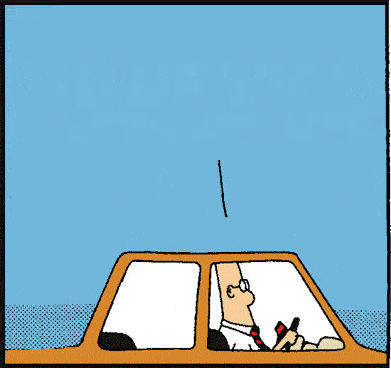

In [ ]:
dilbert_comics = list(data_dir.glob('dilbert/*'))
PIL.Image.open(str(dilbert_comics[3]))

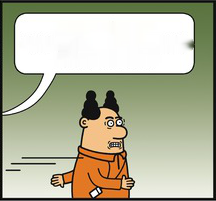

In [ ]:
boss_comics = list(data_dir.glob('boss/*'))
PIL.Image.open(str(boss_comics[0]))

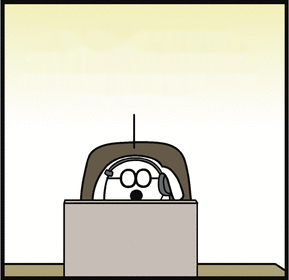

In [ ]:
dogbert_comics = list(data_dir.glob('dogbert/*'))
PIL.Image.open(str(dogbert_comics[4]))

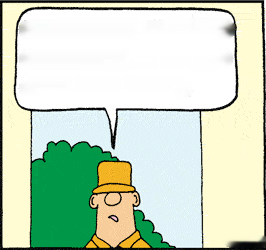

In [ ]:
unknown_comics = list(data_dir.glob('unknown/*'))
PIL.Image.open(str(unknown_comics[0]))

# **CREAZIONE DEI SET DI TRAINING, VALIDAZIONE E TEST**

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
# Imposta il percorso della directory dei dati
# directory = "/content/dataset/dataset_short"
# directory = "/content/dataset/dataset2"
directory = "/content/dataset/dataset3"

# Imposta il percorso di destinazione per i set di dati
train_dir = "/content/dataset/training"
val_dir = "/content/dataset/validation"
test_dir = "/content/dataset/test"

# Percentuali per la suddivisione
train_percent = 0.7
val_percent = 0.2
test_percent = 0.1

# Lista delle classi
class_list = os.listdir(directory)

# Creazione delle directory di destinazione
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Suddivisione dei dati per classe
for class_name in class_list:
    # Ottieni la lista di file nella classe corrente
    class_files = os.listdir(os.path.join(directory, class_name))

    # Mescola casualmente l'ordine dei file
    random.shuffle(class_files)

    # Calcola le dimensioni dei set di dati per la classe corrente
    num_files = len(class_files)
    num_train = int(num_files * train_percent)
    num_val = int(num_files * val_percent)
    num_test = int(num_files * test_percent)

    # Assicurati di avere almeno un'immagine per ogni classe nei set di dati
    num_train = max(num_train, 1)
    num_val = max(num_val, 1)
    num_test = max(num_test, 1)

    # Suddivisione dei file nei set di dati per la classe corrente
    train_files = class_files[:num_train]
    val_files = class_files[num_train:num_train + num_val]
    test_files = class_files[num_train + num_val:]

    # Sposta i file nella directory di destinazione per la classe corrente
    for filename in train_files:
        src_path = os.path.join(directory, class_name, filename)
        dest_path = os.path.join(train_dir, class_name, filename)
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        shutil.move(src_path, dest_path)

    for filename in val_files:
        src_path = os.path.join(directory, class_name, filename)
        dest_path = os.path.join(val_dir, class_name, filename)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        shutil.move(src_path, dest_path)

    for filename in test_files:
        src_path = os.path.join(directory, class_name, filename)
        dest_path = os.path.join(test_dir, class_name, filename)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        shutil.move(src_path, dest_path)

total_files_trd = count_files(train_dir)
print("Numero totale di file nella directory di training:", total_files_trd)
total_files_vd = count_files(val_dir)
print("Numero totale di file nella directory di validazione:", total_files_vd)
total_files_tsd = count_files(test_dir)
print("Numero totale di file nella directory di test:", total_files_tsd)

Numero totale di file nella directory di training: 477
Numero totale di file nella directory di validazione: 136
Numero totale di file nella directory di test: 69


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 477 files belonging to 4 classes.
Found 136 files belonging to 4 classes.
Found 69 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
class_names

['boss', 'dilbert', 'dogbert', 'unknown']

In [ ]:
num_classes = len(class_names)
num_classes

4

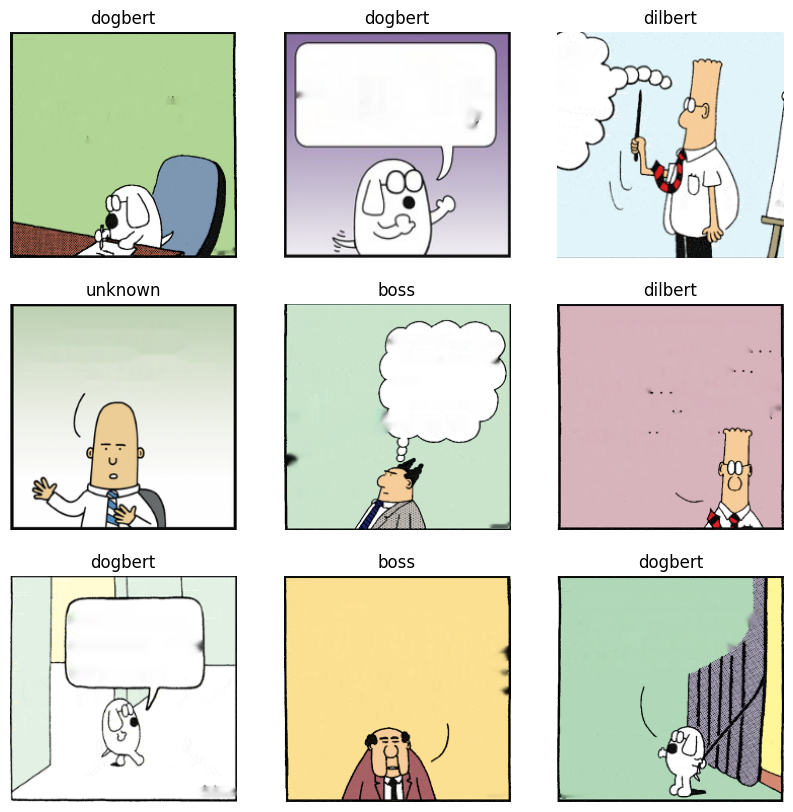

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# **CONFIGURAZIONE DEL DATASET PER LE PRESTAZIONI**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **STANDARDIZZAZIONE DEI DATI**

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notare che i valori dei pixel sono ora in "[0,1].
print(np.min(first_image), np.max(first_image))

0.0 1.0


# **CNN 1**

In [ ]:
CNN_model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(4, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
set_model_name(CNN_model_1, "CNN_model_1")
model_name = CNN_model_1.model_name

Attribute set successfully


In [ ]:
CNN_model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
CNN_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 8)       296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 16)        1

In [ ]:
epochs=100
cnn_1_history = CNN_model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
15/15 [==============================] - 13s 93ms/step - loss: 1.3446 - accuracy: 0.3145 - val_loss: 1.3170 - val_accuracy: 0.3529
Epoch 2/100
15/15 [==============================] - 0s 19ms/step - loss: 1.2980 - accuracy: 0.4403 - val_loss: 1.2612 - val_accuracy: 0.4559
Epoch 3/100
15/15 [==============================] - 0s 20ms/step - loss: 1.1462 - accuracy: 0.5178 - val_loss: 1.1665 - val_accuracy: 0.4485
Epoch 4/100
15/15 [==============================] - 0s 19ms/step - loss: 0.9895 - accuracy: 0.5996 - val_loss: 1.0755 - val_accuracy: 0.5441
Epoch 5/100
15/15 [==============================] - 0s 20ms/step - loss: 0.8738 - accuracy: 0.6457 - val_loss: 0.9761 - val_accuracy: 0.6324
Epoch 6/100
15/15 [==============================] - 0s 19ms/step - loss: 0.7580 - accuracy: 0.7212 - val_loss: 0.8909 - val_accuracy: 0.6618
Epoch 7/100
15/15 [==============================] - 0s 21ms/step - loss: 0.7085 - accuracy: 0.7421 - val_loss: 0.9037 - val_accuracy: 0.6765
Epoch

In [ ]:
CNN_model_1.evaluate(val_ds)

5/5 [==============================] - 0s 9ms/step - loss: 2.7929 - accuracy: 0.7059


[2.792879581451416, 0.7058823704719543]

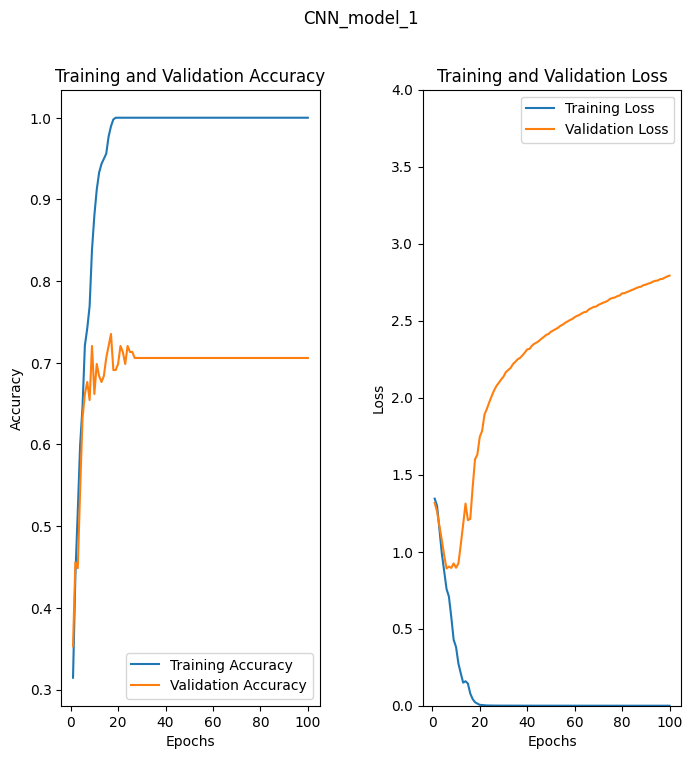

In [ ]:
plot_accuracy_loss(cnn_1_history,model_name,epochs)

In [ ]:
# Salva il modello addestrato
model_h5 = CNN_model_1.save("/content/output/CNN_model_1.h5")

In [ ]:
prepare_environment(out,model_name)

Directory output/CNN_model_1/boss successfully created
Directory output/CNN_model_1/dilbert successfully created
Directory output/CNN_model_1/dogbert successfully created
Directory output/CNN_model_1/unknown successfully created
Directory output/CNN_model_1/to_check successfully created


In [ ]:
f = open(txt_path_im, "w")
write_total_files(image_count)
write_metric_values(cnn_1_history)

In [ ]:
f.write('PERFORMANCE ON TEST DATASET\r\n')

29

In [ ]:
td_evaluation_results = evaluation_model_on_test_dataset(test_ds, '/content/output/CNN_model_1.h5', model_name)

3/3 [==============================] - 0s 60ms/step - loss: 2.5414 - accuracy: 0.7101
CNN_model_1

loss: 2.5413856506347656
accuracy: 0.7101449370384216


In [ ]:
f.write('test accurancy: '+str(td_evaluation_results['accuracy'])+'\r\n')
f.write('test loss: '+str(td_evaluation_results['loss'])+'\r\n')

31

In [ ]:
f.write('TEST DATASET\r\n')
f.write('file_name,class_name,confidence\r\n')

33

In [ ]:
analyze_dataset(ds_test_boss_path, CNN_model_1)

1/1 [==============================] - 0s 238ms/step
The image dataset/test/boss/1996-09-13_1.png most likely belongs to boss with a 99.55 percent confidence.
1/1 [==============================] - 0s 23ms/step
The image dataset/test/boss/2022-05-18_1.png most likely belongs to boss with a 100.00 percent confidence.
1/1 [==============================] - 0s 26ms/step
The image dataset/test/boss/1994-01-24_1.png most likely belongs to boss with a 100.00 percent confidence.
1/1 [==============================] - 0s 30ms/step
The image dataset/test/boss/1998-02-03_1.png most likely belongs to boss with a 100.00 percent confidence.
1/1 [==============================] - 0s 26ms/step
The image dataset/test/boss/2022-04-14_1.png most likely belongs to boss with a 100.00 percent confidence.
1/1 [==============================] - 0s 24ms/step
The image dataset/test/boss/1999-11-18_2.png most likely belongs to boss with a 88.10 percent confidence.
1/1 [==============================] - 0s 25ms/

In [ ]:
f.write('-----'+'\r\n')
f.write('UNKNOWN DATASET'+'\r\n')
f.write('file_name,class_name,confidence\r\n')

33

In [ ]:
analyze_dataset(ds_extra_small_path, CNN_model_1)

1/1 [==============================] - 0s 23ms/step
The image dataset/extra_small_dataset/2006-01-13_2.png most likely belongs to dilbert with a 100.00 percent confidence.
1/1 [==============================] - 0s 23ms/step
The image dataset/extra_small_dataset/2001-11-13_1.png most likely belongs to unknown with a 99.80 percent confidence.
1/1 [==============================] - 0s 21ms/step
The image dataset/extra_small_dataset/2012-03-05_1.png most likely belongs to dilbert with a 99.31 percent confidence.
1/1 [==============================] - 0s 25ms/step
The image dataset/extra_small_dataset/2003-04-16_1.png most likely belongs to unknown with a 100.00 percent confidence.
1/1 [==============================] - 0s 19ms/step
The image dataset/extra_small_dataset/1998-05-31_7.png most likely belongs to dilbert with a 98.60 percent confidence.
1/1 [==============================] - 0s 20ms/step
The image dataset/extra_small_dataset/1998-09-20_0.png most likely belongs to dilbert with 

In [ ]:
f.write('-----'+'\r\n')
f.write('OTHER IMAGES DATASET'+'\r\n')
f.write('file_name,class_name,confidence\r\n')

33

In [ ]:
analyze_dataset(ds_images_path, CNN_model_1)

1/1 [==============================] - 0s 20ms/step
The image images/images_blue.png most likely belongs to dilbert with a 70.16 percent confidence.
1/1 [==============================] - 0s 23ms/step
The image images/red_sunflower.png most likely belongs to boss with a 100.00 percent confidence.
1/1 [==============================] - 0s 23ms/step
The image images/sky.png most likely belongs to dilbert with a 99.91 percent confidence.


In [ ]:
f.close()

In [ ]:
txt_to_csv(txt_path_im,'/content/output/CNN_model_1.csv')

Conversion completed successfully.


In [ ]:
shutil.copy('/content/output/CNN_model_1.csv','/content/gdrive/My Drive/')

'/content/gdrive/My Drive/CNN_model_1.csv'

In [ ]:
!ls "output/$model_name/to_check" | wc -l

0


# **EARLY STOPPING**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# **DATA AUGMENTATION**

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    #new
    # layers.RandomContrast(0.1),
    # layers.RandomBrightness(0.1),
    # layers.RandomCrop(224,224),
    # layers.GaussianNoise(0.1),
    # #layers.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    # #layers.RandomRescaling(0.1),
    # #layers.RandomSaturation(0.1),
    # #layers.ElasticTransform(alpha=1, sigma=50),
  ]
)

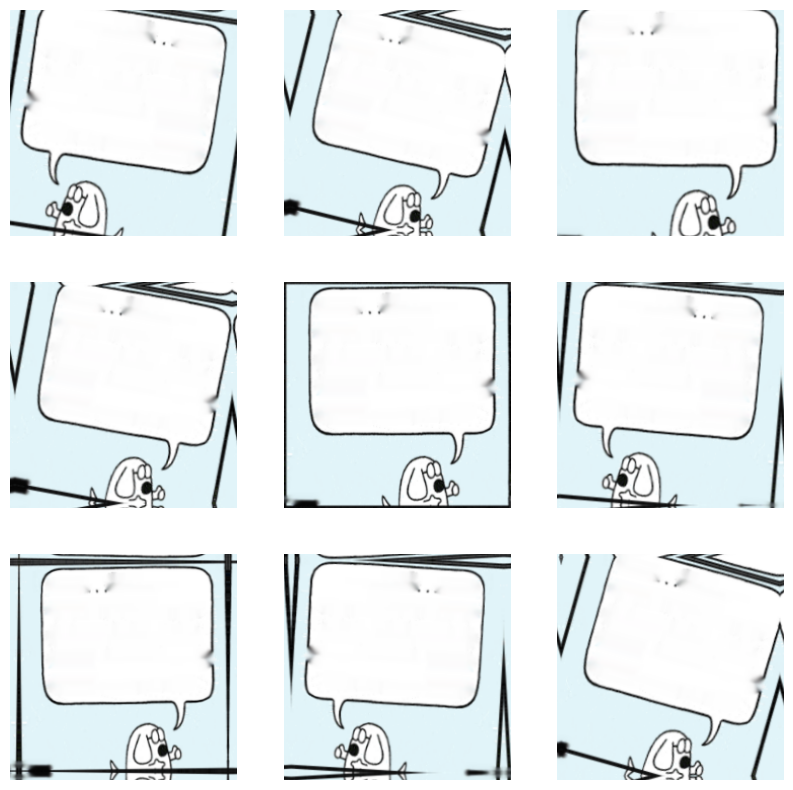

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# **CNN 2**

In [ ]:
CNN_model_2 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(4, 3, padding='same', activation='relu'),#kernel_regularizer=regularizers.l2(0.01))
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu'),#kernel_regularizer=regularizers.l2(0.01))
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),#kernel_regularizer=regularizers.l2(0.01))
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),#kernel_regularizer=regularizers.l2(0.01))
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),#kernel_regularizer=regularizers.l2(0.01))
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),#kernel_regularizer=regularizers.l2(0.01))
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_name = set_model_name(CNN_model_2, "CNN_model_2")
model_name = CNN_model_2.model_name

Attribute set successfully


In [ ]:
CNN_model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
CNN_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 4)       112       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 4)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 8)       296       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 8)        0         
 2D)                                                  

In [ ]:
epochs=100
cnn_2_history = CNN_model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping] #model_checkpoint
)

Epoch 1/100
15/15 [==============================] - 5s 43ms/step - loss: 1.3657 - accuracy: 0.2767 - val_loss: 1.3499 - val_accuracy: 0.2941
Epoch 2/100
15/15 [==============================] - 0s 25ms/step - loss: 1.3472 - accuracy: 0.2830 - val_loss: 1.3292 - val_accuracy: 0.3603
Epoch 3/100
15/15 [==============================] - 0s 23ms/step - loss: 1.3465 - accuracy: 0.2579 - val_loss: 1.3301 - val_accuracy: 0.2868
Epoch 4/100
15/15 [==============================] - 0s 24ms/step - loss: 1.3378 - accuracy: 0.2956 - val_loss: 1.3240 - val_accuracy: 0.3456
Epoch 5/100
15/15 [==============================] - 0s 23ms/step - loss: 1.3342 - accuracy: 0.3040 - val_loss: 1.3163 - val_accuracy: 0.3162
Epoch 6/100
15/15 [==============================] - 0s 24ms/step - loss: 1.3224 - accuracy: 0.2998 - val_loss: 1.3034 - val_accuracy: 0.4338
Epoch 7/100
15/15 [==============================] - 0s 24ms/step - loss: 1.3009 - accuracy: 0.3774 - val_loss: 1.2762 - val_accuracy: 0.3750
Epoch 

In [ ]:
best_epoch_cnn_2 = early_stopping.best_epoch + 1
best_epoch_cnn_2

56

In [ ]:
CNN_model_2.evaluate(val_ds)

5/5 [==============================] - 0s 10ms/step - loss: 0.5094 - accuracy: 0.8529


[0.5094011425971985, 0.8529411554336548]

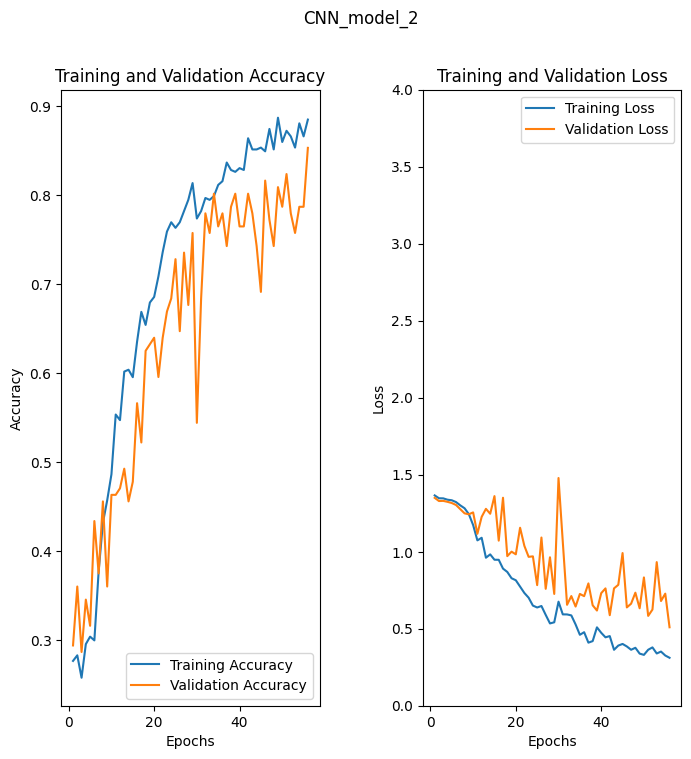

In [ ]:
plot_accuracy_loss(cnn_2_history,model_name,best_epoch_cnn_2)

In [ ]:
# Salva il modello addestrato
model_h5 = CNN_model_2.save("/content/output/CNN_model_2.h5")

In [ ]:
prepare_environment(out,model_name)

Directory output/CNN_model_2/boss successfully created
Directory output/CNN_model_2/dilbert successfully created
Directory output/CNN_model_2/dogbert successfully created
Directory output/CNN_model_2/unknown successfully created
Directory output/CNN_model_2/to_check successfully created


In [ ]:
f = open(txt_path_im_es, "w")
write_total_files(image_count)
write_metric_values(cnn_2_history)

In [ ]:
f.write('PERFORMANCE ON TEST DATASET\r\n')

29

In [ ]:
td_evaluation_results = evaluation_model_on_test_dataset(test_ds, '/content/output/CNN_model_2.h5', model_name)

3/3 [==============================] - 0s 9ms/step - loss: 0.6046 - accuracy: 0.7971
CNN_model_2

loss: 0.6045761108398438
accuracy: 0.7971014380455017


In [ ]:
f.write('test accurancy: '+str(td_evaluation_results['accuracy'])+'\r\n')
f.write('test loss: '+str(td_evaluation_results['loss'])+'\r\n')

31

In [ ]:
f.write('TEST DATASET\r\n')
f.write('file_name,class_name,confidence\r\n')

33

In [ ]:
analyze_dataset(ds_test_boss_path, CNN_model_2)

1/1 [==============================] - 0s 95ms/step
The image dataset/test/boss/1996-09-13_1.png most likely belongs to boss with a 96.69 percent confidence.
1/1 [==============================] - 0s 18ms/step
The image dataset/test/boss/2022-05-18_1.png most likely belongs to boss with a 99.72 percent confidence.
1/1 [==============================] - 0s 20ms/step
The image dataset/test/boss/1994-01-24_1.png most likely belongs to boss with a 97.15 percent confidence.
1/1 [==============================] - 0s 22ms/step
The image dataset/test/boss/1998-02-03_1.png most likely belongs to unknown with a 62.91 percent confidence.
1/1 [==============================] - 0s 20ms/step
The image dataset/test/boss/2022-04-14_1.png most likely belongs to boss with a 98.74 percent confidence.
1/1 [==============================] - 0s 23ms/step
The image dataset/test/boss/1999-11-18_2.png most likely belongs to boss with a 94.95 percent confidence.
1/1 [==============================] - 0s 20ms/st

In [ ]:
f.write('-----'+'\r\n')
f.write('UNKNOWN DATASET'+'\r\n')
f.write('file_name,class_name,confidence\r\n')

33

In [ ]:
analyze_dataset(ds_extra_small_path, CNN_model_2)

1/1 [==============================] - 0s 24ms/step
The image dataset/extra_small_dataset/2006-01-13_2.png most likely belongs to boss with a 79.76 percent confidence.
1/1 [==============================] - 0s 22ms/step
The image dataset/extra_small_dataset/2001-11-13_1.png most likely belongs to dilbert with a 81.84 percent confidence.
1/1 [==============================] - 0s 21ms/step
The image dataset/extra_small_dataset/2012-03-05_1.png most likely belongs to unknown with a 57.89 percent confidence.
1/1 [==============================] - 0s 19ms/step
The image dataset/extra_small_dataset/2003-04-16_1.png most likely belongs to boss with a 50.89 percent confidence.
1/1 [==============================] - 0s 21ms/step
The image dataset/extra_small_dataset/1998-05-31_7.png most likely belongs to unknown with a 67.00 percent confidence.
1/1 [==============================] - 0s 22ms/step
The image dataset/extra_small_dataset/1998-09-20_0.png most likely belongs to dilbert with a 96.86 

In [ ]:
f.write('-----'+'\r\n')
f.write('IMAGES DATASET'+'\r\n')
f.write('file_name,class_name,confidence\r\n')

33

In [ ]:
analyze_dataset(ds_images_path, CNN_model_2)

1/1 [==============================] - 0s 18ms/step
The image images/images_blue.png most likely belongs to dilbert with a 69.22 percent confidence.
1/1 [==============================] - 0s 19ms/step
The image images/red_sunflower.png most likely belongs to dilbert with a 99.96 percent confidence.
1/1 [==============================] - 0s 19ms/step
The image images/sky.png most likely belongs to dilbert with a 68.44 percent confidence.


In [ ]:
f.close()

In [ ]:
txt_to_csv(txt_path_im_es,'/content/output/CNN_model_2.csv')

Conversion completed successfully.


In [ ]:
shutil.copy('/content/output/CNN_model_2.csv','/content/gdrive/My Drive/')

'/content/gdrive/My Drive/CNN_model_2.csv'

In [ ]:
!ls "output/$model_name/to_check" | wc -l

8


# **CNN3**

In [ ]:
resnet_model_fe = Sequential()

pretrained_model= tf.keras.applications.resnet50.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

#resnet_model_fe.add(data_augmentation)
resnet_model_fe.add(pretrained_model)
resnet_model_fe.add(Flatten())
resnet_model_fe.add(Dense(512, activation='relu'))
resnet_model_fe.add(Dropout(0.5))
resnet_model_fe.add(Dense(num_classes, activation='softmax'))

In [ ]:
set_model_name(resnet_model_fe, "ResNet_FE_model")
model_name = resnet_model_fe.model_name

Attribute set successfully


In [ ]:
resnet_model_fe.compile(optimizer=Adam(learning_rate=0.001),loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
resnet_model_fe.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
epochs=100
resnet_fe_history = resnet_model_fe.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]#, model_checkpoint]
)

Epoch 1/100
15/15 [==============================] - 7s 214ms/step - loss: 1.5714 - accuracy: 0.5136 - val_loss: 0.7536 - val_accuracy: 0.7426
Epoch 2/100
15/15 [==============================] - 2s 138ms/step - loss: 0.5474 - accuracy: 0.8155 - val_loss: 0.5167 - val_accuracy: 0.8015
Epoch 3/100
15/15 [==============================] - 2s 159ms/step - loss: 0.3465 - accuracy: 0.8595 - val_loss: 0.4982 - val_accuracy: 0.8088
Epoch 4/100
15/15 [==============================] - 2s 140ms/step - loss: 0.2545 - accuracy: 0.9099 - val_loss: 0.4231 - val_accuracy: 0.8456
Epoch 5/100
15/15 [==============================] - 2s 128ms/step - loss: 0.2053 - accuracy: 0.9308 - val_loss: 0.4271 - val_accuracy: 0.8088
Epoch 6/100
15/15 [==============================] - 2s 128ms/step - loss: 0.1360 - accuracy: 0.9581 - val_loss: 0.4498 - val_accuracy: 0.8309
Epoch 7/100
15/15 [==============================] - 2s 128ms/step - loss: 0.1296 - accuracy: 0.9539 - val_loss: 0.5016 - val_accuracy: 0.8309

In [ ]:
best_epoch_res_net_fe = early_stopping.best_epoch + 1
best_epoch_res_net_fe

19

In [ ]:
resnet_model_fe.evaluate(val_ds)

5/5 [==============================] - 0s 80ms/step - loss: 0.3549 - accuracy: 0.8676


[0.3549102544784546, 0.8676470518112183]

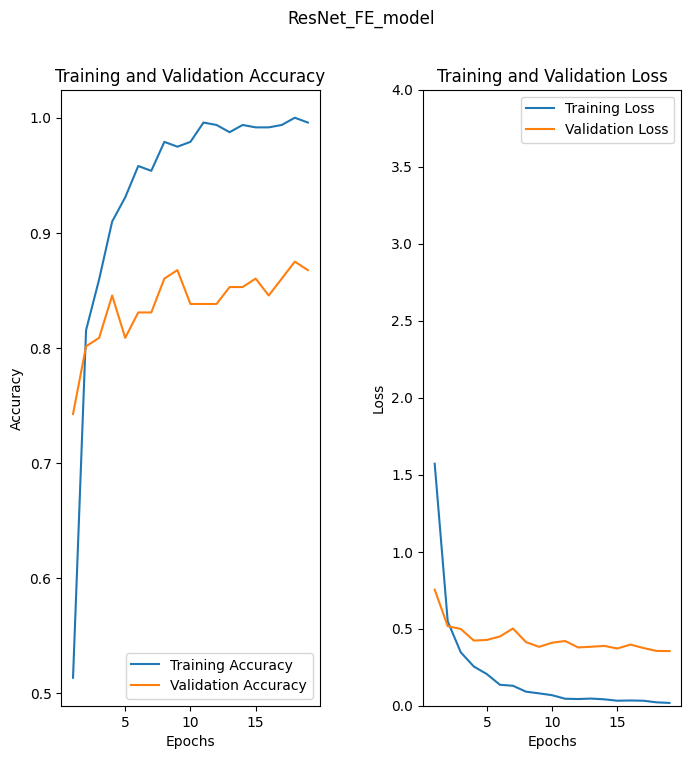

In [ ]:
plot_accuracy_loss(resnet_fe_history, resnet_model_fe.model_name,best_epoch_res_net_fe)

In [ ]:
# Salva il modello addestrato
model_h5 = resnet_model_fe.save("/content/output/ResNet_FE_model.h5")

In [ ]:
prepare_environment(out, model_name)

Directory output/ResNet_FE_model/boss successfully created
Directory output/ResNet_FE_model/dilbert successfully created
Directory output/ResNet_FE_model/dogbert successfully created
Directory output/ResNet_FE_model/unknown successfully created
Directory output/ResNet_FE_model/to_check successfully created


In [ ]:
f = open(txt_path_rn_fe, "w")
write_total_files(image_count)
write_metric_values(resnet_fe_history)

In [ ]:
f.write('PERFORMANCE ON TEST DATASET\r\n')

29

In [ ]:
evaluation_results = evaluation_model_on_test_dataset(test_ds, '/content/output/ResNet_FE_model.h5', model_name)

3/3 [==============================] - 1s 69ms/step - loss: 0.1202 - accuracy: 0.9565
ResNet_FE_model

loss: 0.12018496543169022
accuracy: 0.95652174949646


In [ ]:
f.write('test accurancy: '+str(td_evaluation_results['accuracy'])+'\r\n')
f.write('test loss: '+str(td_evaluation_results['loss'])+'\r\n')

31

In [ ]:
f.write('TEST DATASET\r\n')
f.write('file_name,class_name,confidence\r\n')

33

In [ ]:
analyze_dataset(ds_test_boss_path, resnet_model_fe)

1/1 [==============================] - 1s 927ms/step
The image dataset/test/boss/1996-09-13_1.png most likely belongs to boss with a 99.43 percent confidence.
1/1 [==============================] - 0s 30ms/step
The image dataset/test/boss/2022-05-18_1.png most likely belongs to boss with a 99.75 percent confidence.
1/1 [==============================] - 0s 31ms/step
The image dataset/test/boss/1994-01-24_1.png most likely belongs to boss with a 99.99 percent confidence.
1/1 [==============================] - 0s 24ms/step
The image dataset/test/boss/1998-02-03_1.png most likely belongs to boss with a 99.94 percent confidence.
1/1 [==============================] - 0s 25ms/step
The image dataset/test/boss/2022-04-14_1.png most likely belongs to boss with a 99.62 percent confidence.
1/1 [==============================] - 0s 25ms/step
The image dataset/test/boss/1999-11-18_2.png most likely belongs to dilbert with a 56.33 percent confidence.
1/1 [==============================] - 0s 25ms/s

In [ ]:
f.write('-----'+'\r\n')
f.write('UNKNOWN DATASET'+'\r\n')
f.write('file_name,class_name,confidence\r\n')

33

In [ ]:
analyze_dataset(ds_extra_small_path, resnet_model_fe)

1/1 [==============================] - 0s 25ms/step
The image dataset/extra_small_dataset/2006-01-13_2.png most likely belongs to unknown with a 99.17 percent confidence.
1/1 [==============================] - 0s 25ms/step
The image dataset/extra_small_dataset/2001-11-13_1.png most likely belongs to unknown with a 80.36 percent confidence.
1/1 [==============================] - 0s 25ms/step
The image dataset/extra_small_dataset/2012-03-05_1.png most likely belongs to unknown with a 99.95 percent confidence.
1/1 [==============================] - 0s 27ms/step
The image dataset/extra_small_dataset/2003-04-16_1.png most likely belongs to unknown with a 87.08 percent confidence.
1/1 [==============================] - 0s 24ms/step
The image dataset/extra_small_dataset/1998-05-31_7.png most likely belongs to unknown with a 88.45 percent confidence.
1/1 [==============================] - 0s 27ms/step
The image dataset/extra_small_dataset/1998-09-20_0.png most likely belongs to boss with a 91.

In [ ]:
f.write('-----'+'\r\n')
f.write('IMAGES DATASET'+'\r\n')
f.write('file_name,class_name,confidence\r\n')

33

In [ ]:
analyze_dataset(ds_images_path, resnet_model_fe)

1/1 [==============================] - 0s 34ms/step
The image images/images_blue.png most likely belongs to dogbert with a 99.90 percent confidence.
1/1 [==============================] - 0s 37ms/step
The image images/red_sunflower.png most likely belongs to dogbert with a 75.16 percent confidence.
1/1 [==============================] - 0s 40ms/step
The image images/sky.png most likely belongs to dogbert with a 82.81 percent confidence.


In [ ]:
f.close()

In [ ]:
txt_to_csv(txt_path_rn_fe,'/content/output/ResNet_FE_model.csv')

Conversion completed successfully.


In [ ]:
shutil.copy('/content/output/ResNet_FE_model.csv','/content/gdrive/My Drive/')

'/content/gdrive/My Drive/ResNet_FE_model.csv'

In [ ]:
!ls "output/$model_name/to_check" | wc -l

4


# **CNN 4**

In [ ]:
resnet_model_ft = Sequential()

pretrained_model= tf.keras.applications.resnet50.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')

# Setto trainable = False per i primi 140 strati del modello pre-addestrato
for layer in pretrained_model.layers[:140]:
    layer.trainable=False

# Setto trainable = True per i restanti strati del modello pre-addestrato
for layer in pretrained_model.layers[140:]:
    layer.trainable=True

#resnet_model_ft.add(data_augmentation)
resnet_model_ft.add(pretrained_model)
resnet_model_ft.add(Flatten())
resnet_model_ft.add(Dense(512, activation='relu'))
resnet_model_ft.add(Dropout(0.5))
resnet_model_ft.add(Dense(num_classes, activation='softmax'))

94765736/94765736 [==============================] - 6s 0us/step


In [ ]:
#new
num_layers = len(resnet_model_ft.layers)
print("Numero totale di strati:", num_layers)

Numero totale di strati: 5


In [ ]:
#new
num_layers = len(resnet_model_ft.layers[0].layers)
print("Numero totale di strati:", num_layers)

Numero totale di strati: 176


In [ ]:
set_model_name(resnet_model_ft, "ResNet_FT_model")
model_name = resnet_model_ft.model_name

Attribute set successfully


In [ ]:
resnet_model_ft.compile(optimizer=Adam(learning_rate=0.001),loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
resnet_model_ft.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 16,029,188
Non-trainable params: 8,609,664
_________________________________________________________________


In [ ]:
epochs=100
resnet_ft_history = resnet_model_ft.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]#, model_checkpoint]
)

Epoch 1/100
15/15 [==============================] - 20s 422ms/step - loss: 0.9500 - accuracy: 0.7254 - val_loss: 705.7554 - val_accuracy: 0.4485
Epoch 2/100
15/15 [==============================] - 3s 193ms/step - loss: 0.1056 - accuracy: 0.9623 - val_loss: 180.8441 - val_accuracy: 0.7353
Epoch 3/100
15/15 [==============================] - 3s 175ms/step - loss: 0.0268 - accuracy: 0.9937 - val_loss: 87.2525 - val_accuracy: 0.7794
Epoch 4/100
15/15 [==============================] - 3s 175ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 47.9457 - val_accuracy: 0.7574
Epoch 5/100
15/15 [==============================] - 3s 174ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 19.0941 - val_accuracy: 0.8309
Epoch 6/100
15/15 [==============================] - 3s 177ms/step - loss: 6.8239e-04 - accuracy: 1.0000 - val_loss: 8.9881 - val_accuracy: 0.8603
Epoch 7/100
15/15 [==============================] - 3s 179ms/step - loss: 2.3526e-04 - accuracy: 1.0000 - val_loss: 4.7855 - val_

In [ ]:
best_epoch_res_net_ft = early_stopping.best_epoch + 1
best_epoch_res_net_ft

33

In [ ]:
resnet_model_ft.evaluate(val_ds)

5/5 [==============================] - 0s 81ms/step - loss: 0.1041 - accuracy: 0.9632


[0.10413350909948349, 0.9632353186607361]

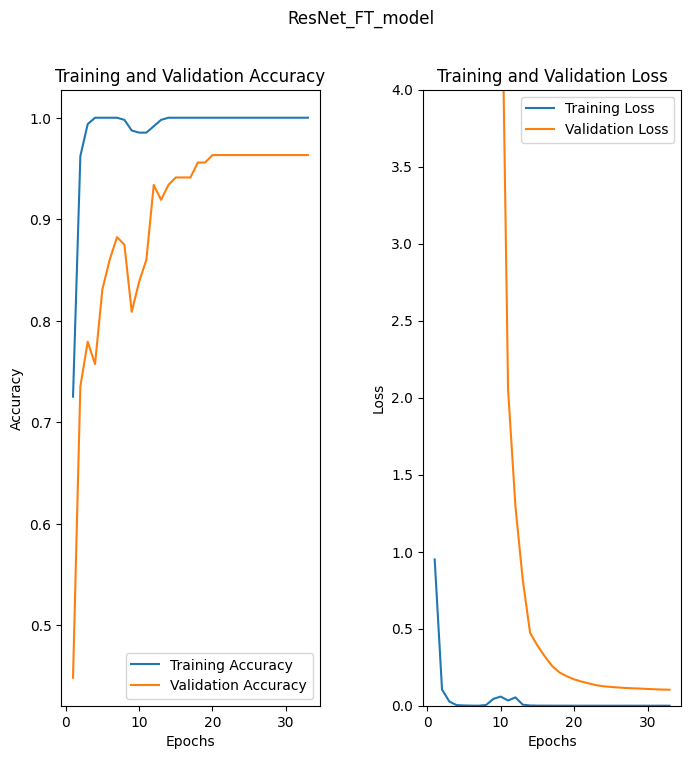

In [ ]:
plot_accuracy_loss(resnet_ft_history, resnet_model_ft.model_name, best_epoch_res_net_ft)

In [ ]:
# Salva il modello addestrato
model_h5 = resnet_model_ft.save("/content/output/ResNet_FT_model.h5")

In [ ]:
prepare_environment(out, resnet_model_ft.model_name)

Directory output/ResNet_FT_model/boss successfully created
Directory output/ResNet_FT_model/dilbert successfully created
Directory output/ResNet_FT_model/dogbert successfully created
Directory output/ResNet_FT_model/unknown successfully created
Directory output/ResNet_FT_model/to_check successfully created


In [ ]:
f = open(txt_path_rn_ft, "w")
write_total_files(image_count)
write_metric_values(resnet_ft_history)

In [ ]:
f.write('PERFORMANCE ON TEST DATASET\r\n')

29

In [ ]:
evaluation_results = evaluation_model_on_test_dataset(test_ds, '/content/output/ResNet_FT_model.h5', model_name)

3/3 [==============================] - 2s 339ms/step - loss: 0.0194 - accuracy: 0.9855
ResNet_FT_model

loss: 0.019392067566514015
accuracy: 0.9855072498321533


In [ ]:
f.write('test accurancy: '+str(td_evaluation_results['accuracy'])+'\r\n')
f.write('test loss: '+str(td_evaluation_results['loss'])+'\r\n')

31

In [ ]:
f.write('TEST DATASET\r\n')
f.write('file_name,class_name,confidence\r\n')

33

In [ ]:
analyze_dataset(ds_test_boss_path, resnet_model_ft)

1/1 [==============================] - 1s 1s/step
The image dataset/test/boss/1996-09-13_1.png most likely belongs to boss with a 100.00 percent confidence.
1/1 [==============================] - 0s 23ms/step
The image dataset/test/boss/2022-05-18_1.png most likely belongs to boss with a 100.00 percent confidence.
1/1 [==============================] - 0s 25ms/step
The image dataset/test/boss/1994-01-24_1.png most likely belongs to boss with a 100.00 percent confidence.
1/1 [==============================] - 0s 24ms/step
The image dataset/test/boss/1998-02-03_1.png most likely belongs to boss with a 100.00 percent confidence.
1/1 [==============================] - 0s 27ms/step
The image dataset/test/boss/2022-04-14_1.png most likely belongs to boss with a 100.00 percent confidence.
1/1 [==============================] - 0s 43ms/step
The image dataset/test/boss/1999-11-18_2.png most likely belongs to boss with a 100.00 percent confidence.
1/1 [==============================] - 0s 37ms/s

In [ ]:
f.write('-----'+'\r\n')
f.write('UNKNOWN DATASET'+'\r\n')
f.write('file_name,class_name,confidence\r\n')

33

In [ ]:
analyze_dataset(ds_extra_small_path, resnet_model_ft)

1/1 [==============================] - 0s 36ms/step
The image dataset/extra_small_dataset/2006-01-13_2.png most likely belongs to unknown with a 99.95 percent confidence.
1/1 [==============================] - 0s 42ms/step
The image dataset/extra_small_dataset/2001-11-13_1.png most likely belongs to unknown with a 99.45 percent confidence.
1/1 [==============================] - 0s 39ms/step
The image dataset/extra_small_dataset/2012-03-05_1.png most likely belongs to unknown with a 100.00 percent confidence.
1/1 [==============================] - 0s 45ms/step
The image dataset/extra_small_dataset/2003-04-16_1.png most likely belongs to unknown with a 97.67 percent confidence.
1/1 [==============================] - 0s 42ms/step
The image dataset/extra_small_dataset/1998-05-31_7.png most likely belongs to unknown with a 100.00 percent confidence.
1/1 [==============================] - 0s 34ms/step
The image dataset/extra_small_dataset/1998-09-20_0.png most likely belongs to dilbert with 

In [ ]:
f.write('-----'+'\r\n')
f.write('IMAGES DATASET'+'\r\n')
f.write('file_name,class_name,confidence\r\n')

33

In [ ]:
analyze_dataset(ds_images_path, resnet_model_ft)

1/1 [==============================] - 0s 42ms/step
The image images/images_blue.png most likely belongs to dogbert with a 57.80 percent confidence.
1/1 [==============================] - 0s 40ms/step
The image images/red_sunflower.png most likely belongs to unknown with a 99.28 percent confidence.
1/1 [==============================] - 0s 23ms/step
The image images/sky.png most likely belongs to dogbert with a 40.07 percent confidence.


In [ ]:
f.close()

In [ ]:
txt_to_csv(txt_path_rn_ft,'/content/output/ResNet_FT_model.csv')

Conversion completed successfully.


In [ ]:
shutil.copy('/content/output/ResNet_FT_model.csv','/content/gdrive/My Drive/')

'/content/gdrive/My Drive/ResNet_FT_model.csv'

In [ ]:
!ls "output/$model_name/to_check" | wc -l

3


# **GRAFICI E TABELLE FINALI**

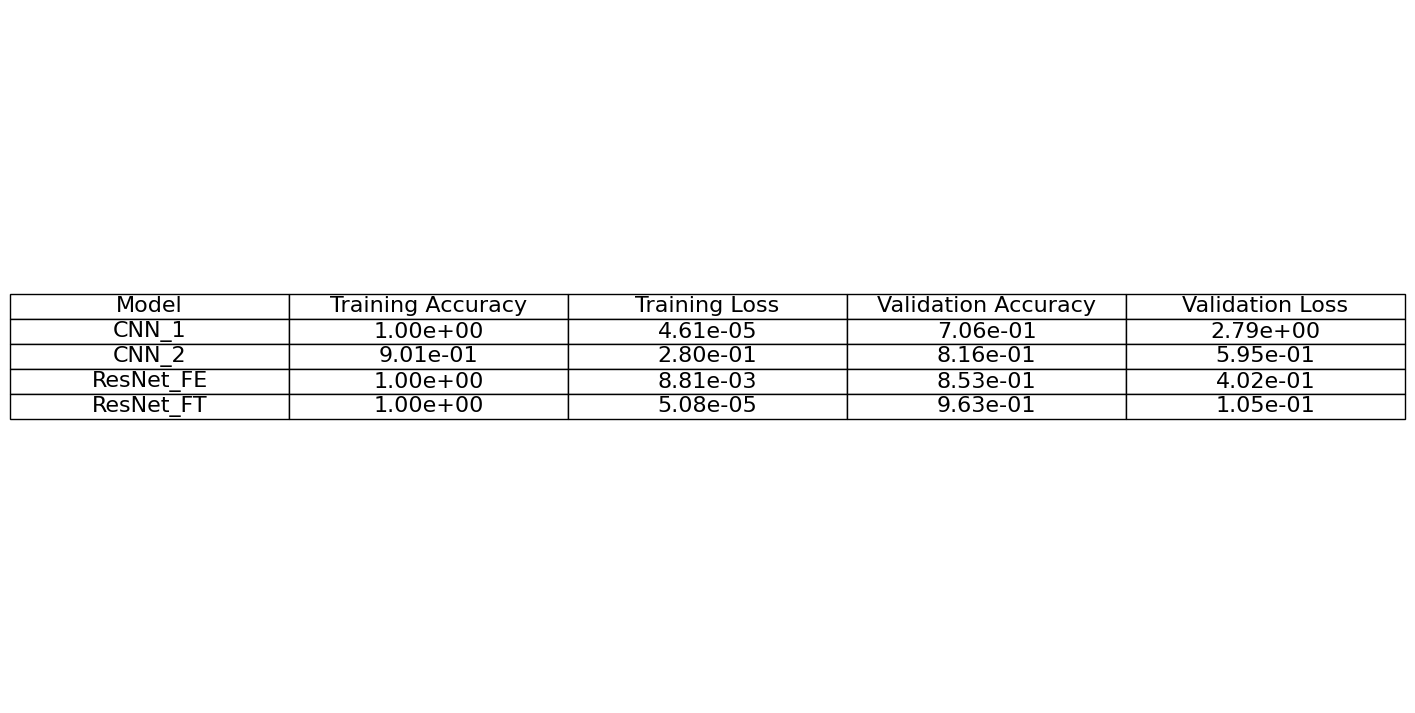

In [ ]:
# define data
data_2 = {'Model': ['CNN_1', 'CNN_2', 'ResNet_FE', 'ResNet_FT'],
        'Training Accuracy': [cnn_1_history.history['accuracy'][-1], cnn_2_history.history['accuracy'][-1],
                     resnet_fe_history.history['accuracy'][-1], resnet_ft_history.history['accuracy'][-1]],
        'Training Loss': [cnn_1_history.history['loss'][-1], cnn_2_history.history['loss'][-1],
                 resnet_fe_history.history['loss'][-1], resnet_ft_history.history['loss'][-1]],
        'Validation Accuracy': [cnn_1_history.history['val_accuracy'][-1], cnn_2_history.history['val_accuracy'][-1],
                         resnet_fe_history.history['val_accuracy'][-1], resnet_ft_history.history['val_accuracy'][-1]],
        'Validation Loss': [cnn_1_history.history['val_loss'][-1], cnn_2_history.history['val_loss'][-1],
                     resnet_fe_history.history['val_loss'][-1], resnet_ft_history.history['val_loss'][-1]]}

# create dataframe
df_2 = pd.DataFrame(data_2)

# # Formatta i valori numerici con notazione scientifica
# df_2 = df_2.applymap('{:.2e}'.format)

# Identifica le colonne numeriche nel DataFrame
numeric_columns = ['Training Accuracy', 'Training Loss', 'Validation Accuracy', 'Validation Loss']

# Applica la formattazione con notazione scientifica solo alle colonne numeriche
df_2[numeric_columns] = df_2[numeric_columns].applymap('{:.2e}'.format)

css = [{'selector': 'table',
        'props': [('max-width', '800px'),
                  ('font-size', '14px'),
                  ('border-collapse', 'collapse')]},
       {'selector': 'th, td',
        'props': [('padding', '8px'),
                  ('border', '1px solid black')]},
       {'selector': 'th',
        'props': [('background-color', 'lightgrey')]}]

styled_table = df_2.style.set_table_styles(css)

# render the styled table to HTML
html_table = styled_table.to_html() #.render()

# create a dummy figure and axes
fig, ax = plt.subplots(figsize=(12, 9))

# hide the axes
ax.axis('off')

# plot the table on the axes
table = ax.table(cellText=df_2.values, colLabels=df_2.columns, cellLoc='center', loc='center')

# Set cell alignment to center
table.auto_set_font_size(False)  # Turn off auto font size adjustment
table.set_fontsize(16) # table.set_fontsize(14)
table.scale(1.5, 1.5) # Increase table size # table.scale(1.2, 1.2)

# save the table as a PNG image
plt.savefig(out_plot + 'metrics_table.png', bbox_inches='tight', pad_inches=0.5)

In [ ]:
desired_num_epochs = 100

# Accedi all'accuratezza dell'addestramento e della validazione dall'oggetto history
train_accuracy_cnn_2 = cnn_2_history.history['accuracy']
val_accuracy_cnn_2= cnn_2_history.history['val_accuracy']
# Accedi alla loss dell'addestramento e della validazione dall'oggetto history
train_loss_cnn_2 = cnn_2_history.history['loss']
val_loss_cnn_2= cnn_2_history.history['val_loss']

# # Accedi all'accuratezza dell'addestramento e della validazione dall'oggetto history
train_accuracy_resnet_fe = resnet_fe_history.history['accuracy']
val_accuracy_resnet_fe  = resnet_fe_history.history['val_accuracy']
# Accedi alla loss dell'addestramento e della validazione dall'oggetto history
train_loss_resnet_fe = resnet_fe_history.history['loss']
val_loss_resnet_fe = resnet_fe_history.history['val_loss']

# Accedi all'accuratezza dell'addestramento e della validazione dall'oggetto history
train_accuracy_resnet_ft = resnet_ft_history.history['accuracy']
val_accuracy_resnet_ft = resnet_ft_history.history['val_accuracy']
# Accedi alla loss dell'addestramento e della validazione dall'oggetto history
train_loss_resnet_ft = resnet_ft_history.history['loss']
val_loss_resnet_ft = resnet_ft_history.history['val_loss']

# Trova l'indice dell'epoca con la loss inferiore
best_loss_cnn_2_index = val_loss_cnn_2.index(min(val_loss_cnn_2))

# Estendi i valori di accuratezza e loss fino a raggiungere le 100 epoche
train_accuracy_cnn_2_extended = train_accuracy_cnn_2[:best_loss_cnn_2_index+1] + [max(train_accuracy_cnn_2)] * (desired_num_epochs - best_loss_cnn_2_index - 1)
val_accuracy_cnn_2_extended = val_accuracy_cnn_2[:best_loss_cnn_2_index+1] + [max(val_accuracy_cnn_2)] * (desired_num_epochs - best_loss_cnn_2_index - 1)
train_loss_cnn_2_extended = train_loss_cnn_2[:best_loss_cnn_2_index+1] + [train_loss_cnn_2[best_loss_cnn_2_index]] * (desired_num_epochs - best_loss_cnn_2_index - 1)
val_loss_cnn_2_extended = val_loss_cnn_2[:best_loss_cnn_2_index+1] + [val_loss_cnn_2[best_loss_cnn_2_index]] * (desired_num_epochs - best_loss_cnn_2_index - 1)

# # Ripeti il processo per gli altri modelli (fe e ft)
best_loss_resnet_fe_index = val_loss_resnet_fe.index(min(val_loss_resnet_fe))
train_accuracy_resnet_fe_extended = train_accuracy_resnet_fe[:best_loss_resnet_fe_index+1] + [max(train_accuracy_resnet_fe)] * (desired_num_epochs - best_loss_resnet_fe_index - 1)
val_accuracy_resnet_fe_extended = val_accuracy_resnet_fe[:best_loss_resnet_fe_index+1] + [max(val_accuracy_resnet_fe)] * (desired_num_epochs - best_loss_resnet_fe_index - 1)
train_loss_resnet_fe_extended = train_loss_resnet_fe[:best_loss_resnet_fe_index+1] + [train_loss_resnet_fe[best_loss_resnet_fe_index]] * (desired_num_epochs - best_loss_resnet_fe_index - 1)
val_loss_resnet_fe_extended = val_loss_resnet_fe[:best_loss_resnet_fe_index+1] + [val_loss_resnet_fe[best_loss_resnet_fe_index]] * (desired_num_epochs - best_loss_resnet_fe_index - 1)

best_loss_resnet_ft_index = val_loss_resnet_ft.index(min(val_loss_resnet_ft))
train_accuracy_resnet_ft_extended = train_accuracy_resnet_ft[:best_loss_resnet_ft_index+1] + [max(train_accuracy_resnet_ft)] * (desired_num_epochs - best_loss_resnet_ft_index - 1)
val_accuracy_resnet_ft_extended = val_accuracy_resnet_ft[:best_loss_resnet_ft_index+1] + [max(val_accuracy_resnet_ft)] * (desired_num_epochs - best_loss_resnet_ft_index - 1)
train_loss_resnet_ft_extended = train_loss_resnet_ft[:best_loss_resnet_ft_index+1] + [train_loss_resnet_ft[best_loss_resnet_ft_index]] * (desired_num_epochs - best_loss_resnet_ft_index - 1)
val_loss_resnet_ft_extended = val_loss_resnet_ft[:best_loss_resnet_ft_index+1] + [val_loss_resnet_ft[best_loss_resnet_ft_index]] * (desired_num_epochs - best_loss_resnet_ft_index - 1)

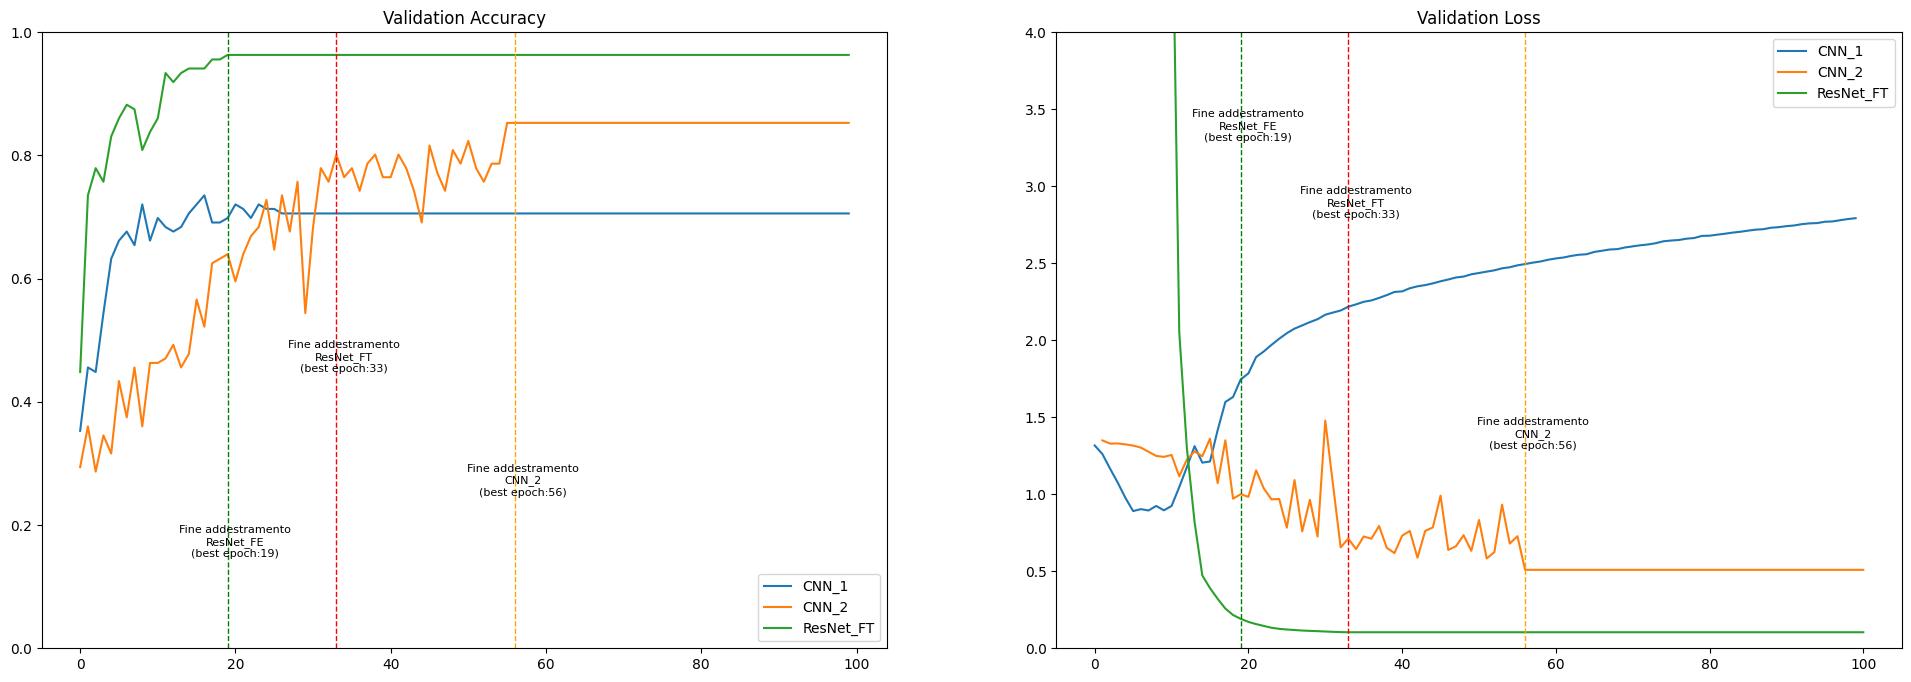

In [ ]:
plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.plot(cnn_1_history.history['val_accuracy'], label='CNN_1')
plt.plot(range(0, desired_num_epochs), val_accuracy_cnn_2_extended, label='CNN_2')
# plt.plot(range(0, desired_num_epochs), val_accuracy_resnet_fe_extended, label='ResNet_FE')
plt.plot(range(0, desired_num_epochs), val_accuracy_resnet_ft_extended, label='ResNet_FT')
plt.ylim(0, 1)

plt.axvline(best_loss_cnn_2_index+1, color="orange", ls="--", lw="1") # num_epochs_trained_es
# Aggiungi label alla riga verticale con dimensione del testo ridotta
label_xpos_cnn_2 = best_loss_cnn_2_index + 2  # Imposta la posizione x della label
label_ypos_cnn_2 = 0.3  # Imposta la posizione y della label
plt.text(label_xpos_cnn_2, label_ypos_cnn_2, 'Fine addestramento\nCNN_2\n(best epoch:'+str(best_loss_cnn_2_index+1)+')', va='top', ha='center', fontsize=8)

plt.axvline(best_loss_resnet_fe_index+1, color="green", ls="--", lw="1") # num_epochs_trained_fe
# Aggiungi label alla riga verticale con dimensione del testo ridotta
label_xpos_resnet_fe = best_loss_resnet_fe_index + 2  # Imposta la posizione x della label
label_ypos_resnet_fe = 0.2  # Imposta la posizione y della label
plt.text(label_xpos_resnet_fe, label_ypos_resnet_fe, 'Fine addestramento\nResNet_FE\n(best epoch:'+str(best_loss_resnet_fe_index+1)+')', va='top', ha='center', fontsize=8)

plt.axvline(best_loss_resnet_ft_index+1, color="red", ls="--", lw="1") # num_epochs_trained_ft
# Aggiungi label alla riga verticale con dimensione del testo ridotta
label_xpos_resnet_ft = best_loss_resnet_ft_index + 2  # Imposta la posizione x della label
label_ypos_resnet_ft = 0.5  # Imposta la posizione y della label
plt.text(label_xpos_resnet_ft, label_ypos_resnet_ft, 'Fine addestramento\nResNet_FT\n(best epoch:'+str(best_loss_resnet_ft_index+1)+')', va='top', ha='center', fontsize=8)

plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(cnn_1_history.history['val_loss'], label='CNN_1')
plt.plot(range(1, desired_num_epochs+1), val_loss_cnn_2_extended, label='CNN_2')
# plt.plot(range(1, desired_num_epochs+1), val_loss_resnet_fe_extended, label='ResNet_FE')
plt.plot(range(1, desired_num_epochs+1), val_loss_resnet_ft_extended, label='ResNet_FT')
plt.ylim(0, 4)

plt.axvline(best_loss_cnn_2_index+1, color="orange", ls="--", lw="1") # num_epochs_trained_es
# Aggiungi label alla riga verticale con dimensione del testo ridotta
label_xpos_cnn_2 = best_loss_cnn_2_index + 2  # Imposta la posizione x della label
label_ypos_cnn_2 = 1.5  # Imposta la posizione y della label
plt.text(label_xpos_cnn_2, label_ypos_cnn_2, 'Fine addestramento\nCNN_2\n(best epoch:'+str(best_loss_cnn_2_index+1)+')', va='top', ha='center', fontsize=8)

plt.axvline(best_loss_resnet_fe_index+1, color="green", ls="--", lw="1") # num_epochs_trained_fe
# Aggiungi label alla riga verticale con dimensione del testo ridotta
label_xpos_resnet_fe = best_loss_resnet_fe_index + 2  # Imposta la posizione x della label
label_ypos_resnet_fe = 3.5  # Imposta la posizione y della label
plt.text(label_xpos_resnet_fe, label_ypos_resnet_fe, 'Fine addestramento\nResNet_FE\n(best epoch:'+str(best_loss_resnet_fe_index+1)+')', va='top', ha='center', fontsize=8)

plt.axvline(best_loss_resnet_ft_index+1, color="red", ls="--", lw="1") # num_epochs_trained_ft
# Aggiungi label alla riga verticale con dimensione del testo ridotta
label_xpos_resnet_ft = best_loss_resnet_ft_index + 2  # Imposta la posizione x della label
label_ypos_resnet_ft = 3  # Imposta la posizione y della label
plt.text(label_xpos_resnet_ft, label_ypos_resnet_ft, 'Fine addestramento\nResNet_FT\n(best epoch:'+str(best_loss_resnet_ft_index+1)+')', va='top', ha='center', fontsize=8)

plt.legend(loc='upper right')
plt.title('Validation Loss')

plt.savefig(out_plot + 'validation_metrics_plot.png')
plt.show()

In [ ]:
shutil.make_archive("/content/output/CNN_model_1", 'zip', "/content/output/CNN_model_1")
shutil.make_archive("/content/output/CNN_model_2", 'zip', "/content/output/CNN_model_2")
shutil.make_archive("/content/output/ResNet_FE_model", 'zip', "/content/output/ResNet_FE_model")
shutil.make_archive("/content/output/ResNet_FT_model", 'zip', "/content/output/ResNet_FT_model")

'/content/output/ResNet_FT_model.zip'

In [ ]:
from google.colab import files

files.download("/content/output/CNN_model_1.csv")
files.download("/content/output/CNN_model_2.csv")
files.download("/content/output/ResNet_FE_model.csv")
files.download("/content/output/ResNet_FT_model.csv")

files.download("/content/plots/CNN_model_1_accuracy_loss_plot.png")
files.download("/content/plots/CNN_model_2_accuracy_loss_plot.png")
files.download("/content/plots/ResNet_FE_model_accuracy_loss_plot.png")
files.download("/content/plots/ResNet_FT_model_accuracy_loss_plot.png")
files.download("/content/plots/metrics_table.png")
files.download("/content/plots/validation_metrics_plot.png")

files.download("/content/output/CNN_model_1.zip")
files.download("/content/output/CNN_model_2.zip")
files.download("/content/output/ResNet_FE_model.zip")
files.download("/content/output/ResNet_FT_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>